In [1]:
import jax.numpy as jnp
import b3d
import os
import trimesh
import matplotlib.pyplot as plt
import jax
import numpy as np
from b3d.bayes3d.image_likelihoods import (
    gaussian_iid_pix_likelihood_vec,
    threedp3_gmm_likelihood_vec,
    kray_likelihood_intermediate_vec,
)

In [2]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

h, w, fx, fy, cx, cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(
        scale * h, scale * w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0
    )
    for scale in [9]
]

linear_pose_from_points = (
    lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
        jnp.array([0.0, -0.8, 0.1]), jnp.zeros(3)
    ).inv()
    @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2)
)

point1 = jnp.array([-0.05, -0.25, 0])
point2 = jnp.array([0.2, 1.5, 0])

alphas = jnp.linspace(-0.05, 1.5, 401)

vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

linear_poses = vec_fun(point1, point2, alphas)
transformed_vertices = jax.vmap(
    lambda i: linear_poses[i].apply(object_library.vertices)
)(jnp.arange(len(linear_poses)))


def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        vertices, faces, jnp.concatenate([attributes, vertices[..., -1:]], axis=-1)
    )


N = len(linear_poses)

all_images = [
    render_rgbd_many(
        r,
        transformed_vertices,
        object_library.faces,
        jnp.tile(object_library.attributes, (N, 1, 1)),
    )
    for r in [renderers[0]]
]

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [3]:
images = all_images[0]
rendered_imgs = images
gt_image = images[0]
gt_near_ind = len(alphas) // 6
gt_far_ind = 4 * len(alphas) // 6
gt_image = images[gt_near_ind, ..., :3] + images[gt_far_ind, ..., :3]
gt_image_depth = np.array(images[gt_near_ind, ..., 3] + images[gt_far_ind, ..., 3])
gt_image_depth[gt_image_depth == 0] = 10.0
gt_image_depth = jnp.array(gt_image_depth)

observed_image = jnp.concatenate([gt_image, gt_image_depth[..., None]], axis=-1)

In [4]:
# gaussian iid args
gaussian_iid_pix_likelihood_args = {
    "rgb_tolerance": 50.0,
    "depth_tolerance": 0.05,
    "outlier_prob": 0.01,
}

# GMM args
threedp3_gmm_likelihood_args = {
    "variance": 0.5,
    "outlier_prob": 0.1,
    "outlier_volume": 10**3,
    "filter_size": 3,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

# ray-tracing likelihood args
kray_likelihood_args = {
    "color_tolerance": 50.0,  # 100
    "depth_tolerance": 0.01,  # 0.005
    "inlier_score": 2.5,
    "outlier_prob": 0.005,
    "multiplier": 1.0,  # 10000.0
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

In [5]:
# gaussian iid args
gaussian_iid_pix_likelihood_args = {
    "rgb_tolerance": 50.0,
    "depth_tolerance": 0.025,
    "outlier_prob": 0.01,
}

# GMM args
threedp3_gmm_likelihood_args = {
    "variance": 0.1,
    "outlier_prob": 0.1,
    "outlier_volume": 10**3,
    "filter_size": 3,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

# ray-tracing likelihood args
kray_likelihood_args = {
    "color_tolerance": 50.0,
    "depth_tolerance": 0.01,
    "inlier_score": 25,  # 2.5,
    "outlier_prob": 0.005,
    "multiplier": 10.0,
    "intrinsics": (
        100,
        100,
        200.0,
        200.0,
        50.0,
        50.0,
        0.01,
        10.0,
    ),
}

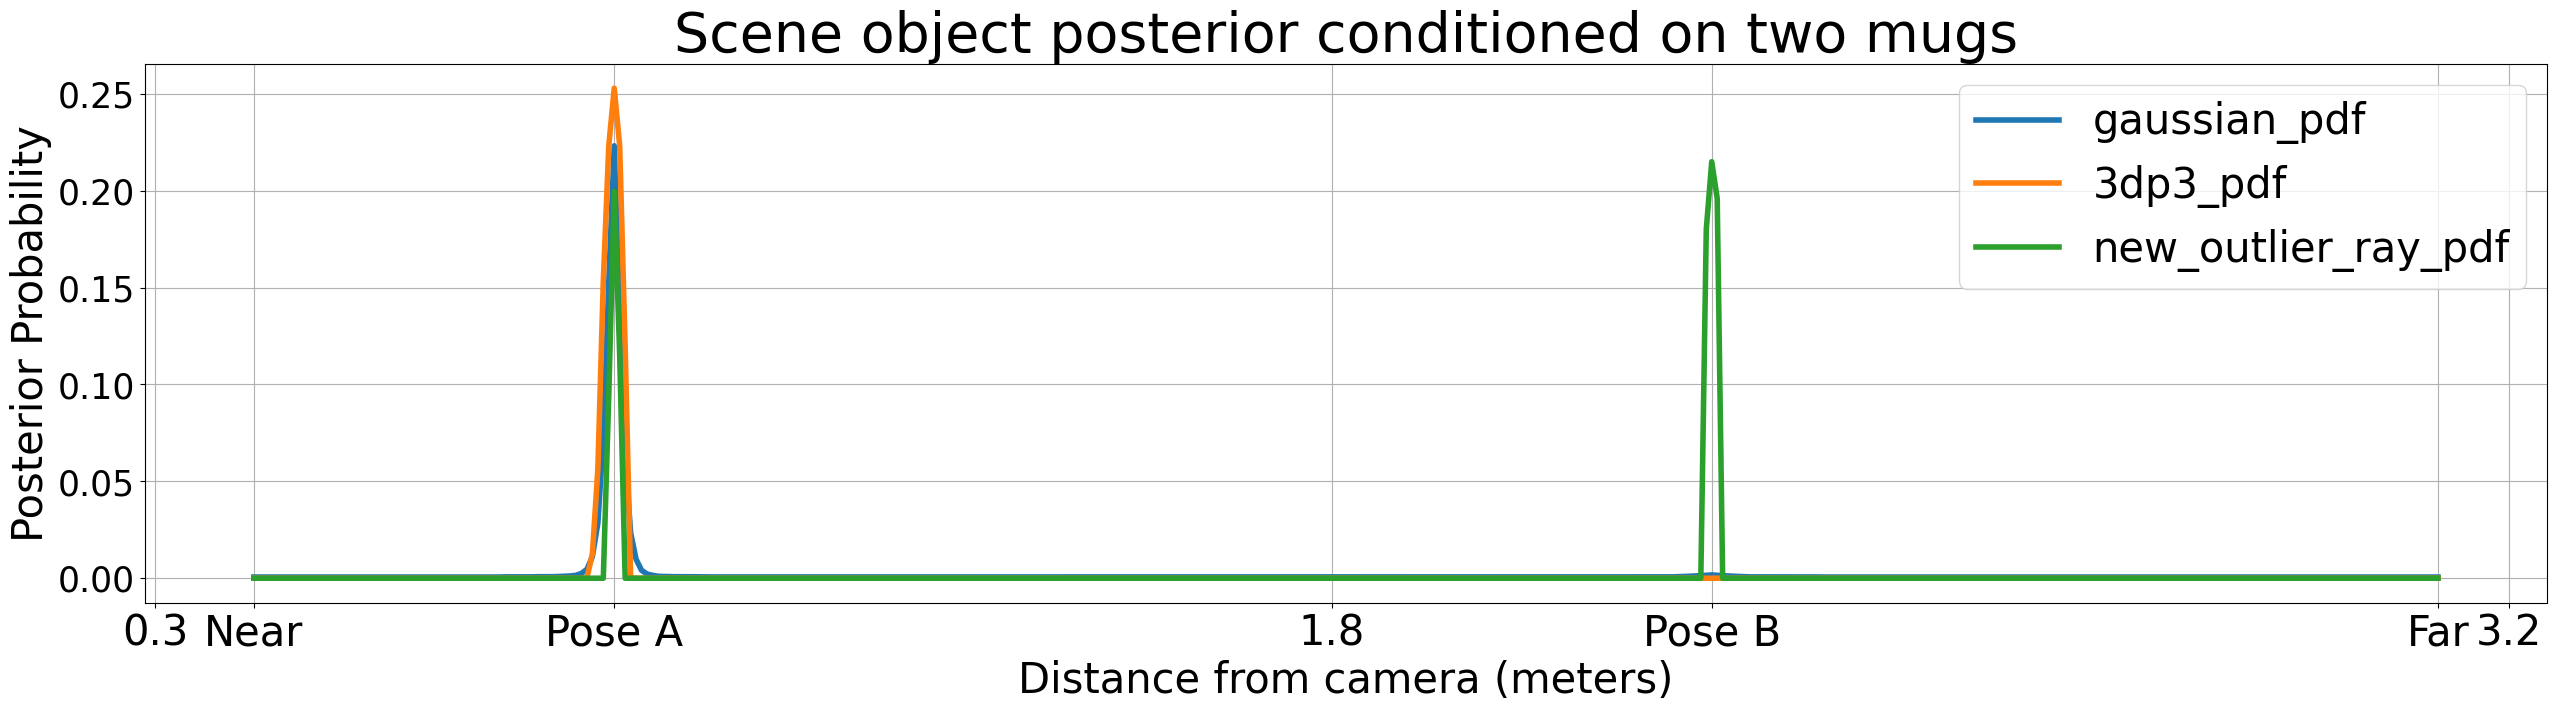

In [6]:
gaussian_logpdfs, _ = gaussian_iid_pix_likelihood_vec(
    observed_image, rendered_imgs, gaussian_iid_pix_likelihood_args
)
threedp3_logpdfs, _ = threedp3_gmm_likelihood_vec(
    observed_image, rendered_imgs, threedp3_gmm_likelihood_args
)
ray_outlier_logpdfs, _ = kray_likelihood_intermediate_vec(
    observed_image, rendered_imgs, kray_likelihood_args
)


fig, axes = plt.subplots(1, 1, figsize=(31, 7))
distances = linear_poses.pos[:, 2]
axes.plot(
    distances,
    b3d.normalize_log_scores(gaussian_logpdfs),
    alpha=1,
    linewidth=4,
    label="gaussian_pdf",
)
# axes.plot(distances, jnp.clip(b3d.normalize_log_scores(threedp3_logpdfs), 1e-3,1), alpha=1, linewidth=4, label='3dp3_pdf')
axes.plot(
    distances,
    b3d.normalize_log_scores(threedp3_logpdfs),
    alpha=1,
    linewidth=4,
    label="3dp3_pdf",
)

axes.plot(
    distances,
    b3d.normalize_log_scores(ray_outlier_logpdfs),
    alpha=1,
    linewidth=4,
    label="new_outlier_ray_pdf",
)
num_ticks = 3

xticks = list(np.linspace(0.35, 3.25, num_ticks))
axes.set_xticks(
    xticks
    + [
        linear_poses.pos[gt_near_ind, 2],
        linear_poses.pos[gt_far_ind, 2],
        linear_poses.pos[0, 2],
        linear_poses.pos[-1, 2],
    ]
)
axes.set_xticklabels(
    ["%.1f" % f for f in xticks] + ["Pose A", "Pose B", "Near", "Far"], fontsize=30
)
axes.tick_params(axis="y", labelsize=25)
# axes.set_ylim(0.0, 0.1)

title = "Scene object posterior conditioned on two mugs"
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
# alpha value: pose = (1 - alpha) * point1 + alpha * point2
plt.xlabel("Distance from camera (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)
# axes.set_yscale('log')
axes.grid()
# plt.savefig('posterior_mode_volume.png',bbox_inches = "tight")

In [47]:
plot_ims = [observed_image[..., :3]]

transformed_vertices = jax.vmap(
    lambda i: linear_poses[i].apply(object_library.vertices)
)(jnp.arange(len(linear_poses)))

images = jnp.array(images)
selected_ims = images[jnp.array([0, gt_near_ind, gt_far_ind, -1]), ...]
plot_ims += [*selected_ims[..., :3]]
plot_ims = jnp.stack(plot_ims)
labels = ["Conditioned Im", "Near", "Pose A", "Pose B", "Far"]

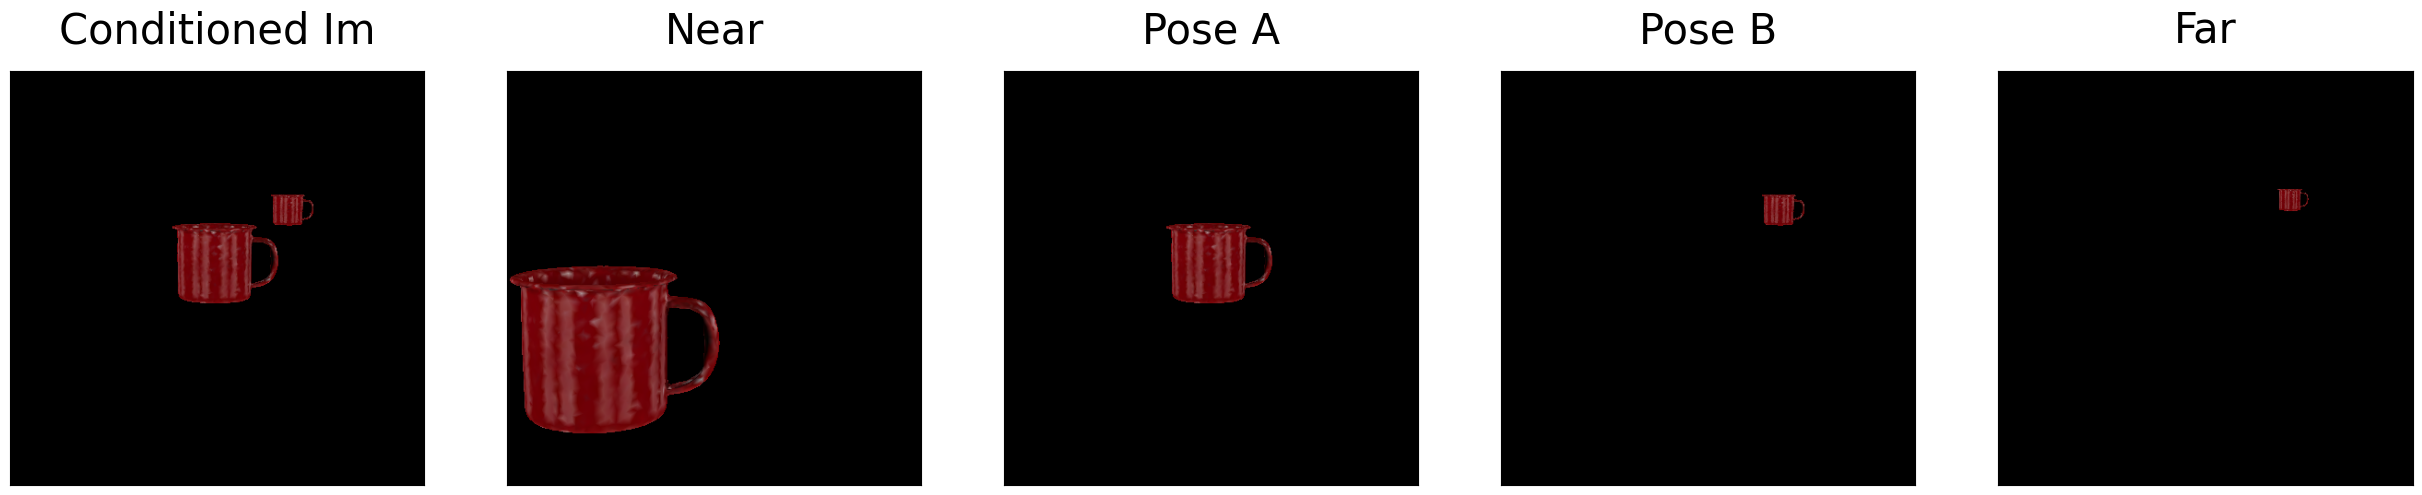

In [66]:
f, axarr = plt.subplots(1, len(plot_ims), figsize=(31, 7))
for ind, im in enumerate(plot_ims):
    axarr[ind].imshow(im)
    axarr[ind].set_xticklabels([])
    axarr[ind].set_xticks([])
    axarr[ind].set_yticklabels([])
    axarr[ind].set_yticks([])
    axarr[ind].set_title(labels[ind], fontsize=30, pad=20)